In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [2]:
fileName ='../data_ta/raw/icen_setengah.bin'
ecg_dir = '../data_ta/ecg/Polar_icen_setengah_ECG.txt'
hr_dir = '../data_ta/hr/Polar_icen_setengah_HR.txt'
rr_dir = '../data_ta/rr/icen-setengah.csv'

# Read Data Reference 
hr = pd.read_csv(hr_dir, delimiter=';')
ecg = pd.read_csv(ecg_dir, delimiter=';')
rr = pd.read_csv(rr_dir)

HR = np.array(hr.get("HR [bpm]"))
ECG = np.array(ecg.get("ecg [uV]"))
RR = np.array(rr.get("Data Set 1:Respiration Rate(bpm)"))
RR_WAVE = np.array(rr.get("Data Set 1:Force(N)"))
rr_cleaned = rr['Data Set 1:Respiration Rate(bpm)'].dropna()

(153,)
(19783,)
(16,)
(1572,)


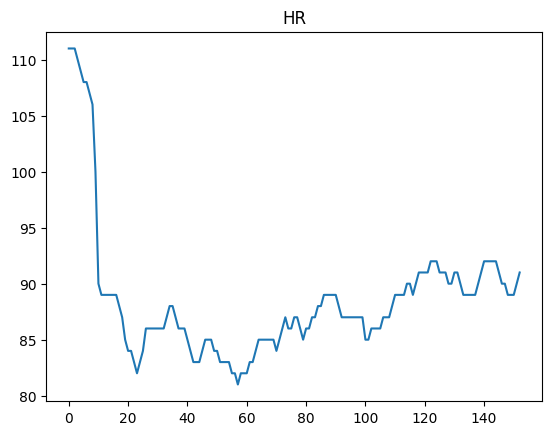

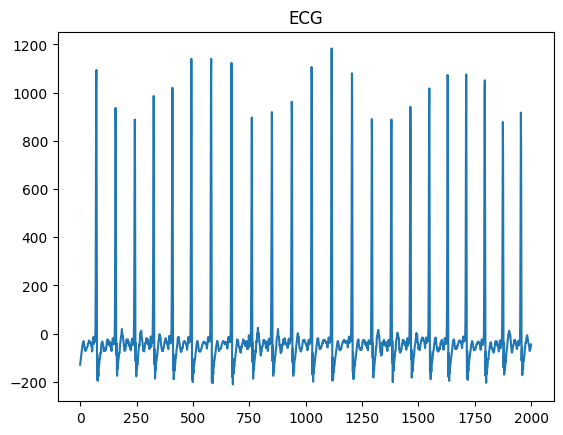

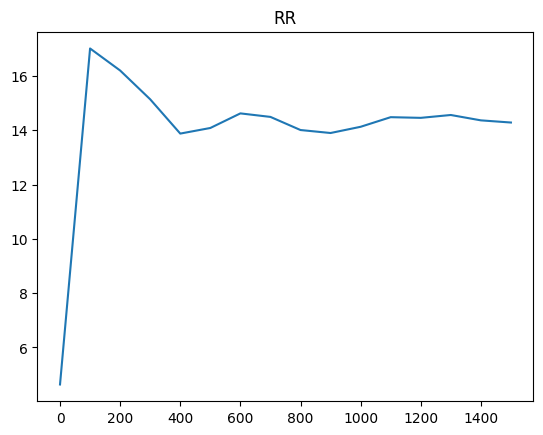

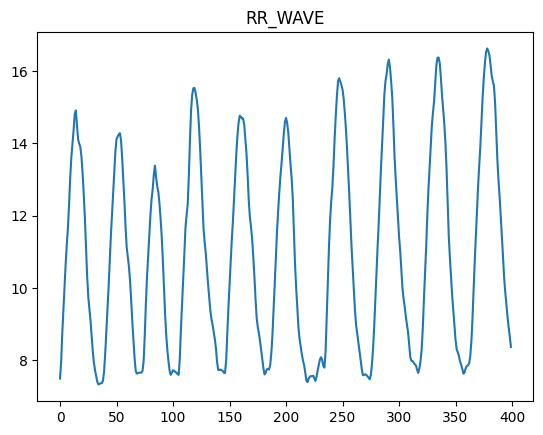

In [3]:
print(HR.shape)
print(ECG.shape)
print(rr_cleaned.shape)
print(RR_WAVE.shape)

plt.figure(1)
plt.title("HR")
plt.plot(HR,label="HR")
plt.figure(2)
plt.title("ECG")
plt.plot(ECG[-2000:],label="ECG")
plt.figure(3)
plt.title("RR")
plt.plot(rr_cleaned,label="RR")
plt.figure(4)
plt.title("RR_WAVE")
plt.plot(RR_WAVE[:400],label="RR WAVE")

In [4]:

from scipy import signal
def read_raw(fileName):
    numADCSamples = 200 # number of ADC samples per chirp
    numADCBits = 16 # number of ADC bits per sample
    numRX = 4 # number of receivers
    numLanes = 2 # do not change. number of lanes is always 2
    isReal = 0 # set to 1 if real only data, 0 if complex data0
    fid = open(fileName,'rb')
    adcData = np.fromfile(fid, dtype='int16')
    if numADCBits != 16:
        l_max = 2**(numADCBits-1)-1
        adcData[adcData > l_max] = adcData[adcData > l_max] - 2**numADCBits
    fid.close()
    # fileSize = adcData.shape[0]
    fileSize = 12288000

    if isReal:
        numChirps = fileSize//numADCSamples//numRX
        LVDS = np.zeros((fileSize,), dtype=np.int16)
        LVDS = adcData.reshape(numADCSamples*numRX, numChirps, order='F').T
    else:
        numChirps = fileSize//2//numADCSamples//numRX
        LVDS = np.zeros((fileSize//2,), dtype=np.complex64)
        adcData = signal.resample(adcData, 12288000)
        counter = 0
        for i in range(0, fileSize-1, 4):
            LVDS[counter] = adcData[i] + 1j*adcData[i+2]
            LVDS[counter+1] = adcData[i+1] + 1j*adcData[i+3]
            counter += 2
        LVDS = signal.resample(LVDS, 6144000)
        LVDS = LVDS.reshape(numADCSamples*numRX, numChirps, order='F').T

    adcData = np.zeros((numRX,numChirps*numADCSamples), dtype=np.complex64)
    for row in range(numRX):
        for i in range(numChirps):
            adcData[row, i*numADCSamples:(i+1)*numADCSamples] = LVDS[i, row*numADCSamples:(row+1)*numADCSamples]

    retVal = adcData
    return retVal

In [5]:
Radar_data = read_raw(fileName)

In [6]:
Radar_data.shape

(4, 1536000)

In [7]:
# Setting Radar
n_rx = 4 
n_fft = 1024
data_len = 3000
n_adc = 256
n_chirp = 2
# Reshape Data 
raw_data = Radar_data
raw_new =raw_data.reshape((n_rx,n_adc*n_chirp,-1), order='F')
raw_new.shape


(4, 512, 3000)

In [8]:
def Range_FFT(InputData):
    OutputData = np.zeros((n_rx, n_fft, data_len), dtype=complex)
    dc_removal = np.zeros((n_rx, n_fft//2, data_len), dtype=complex)
    for i in range(n_rx):
        for j in range(data_len):
            window = np.hamming(n_fft)
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=1024)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], n_fft, hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],n_fft//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(n_fft//2),j]-(clutter[i,range(0, n_fft//2),j])
    return OutputData

In [9]:
# Lakukan proses FFT
FFT_hasil = Range_FFT(raw_new) # hasil FFT
Hasil_mti = MTI(FFT_hasil)

In [10]:
# Hasil MTI untuk setiap antena 
Antena1 = Hasil_mti[0,:,:]
Antena2 = Hasil_mti[1,:,:]
Antena3 = Hasil_mti[2,:,:]
Antena4 = Hasil_mti[3,:,:]

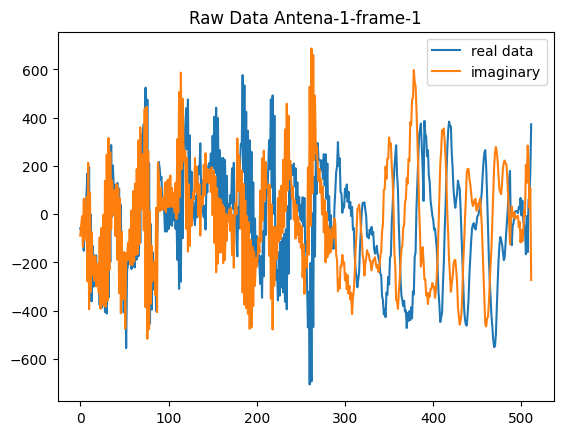

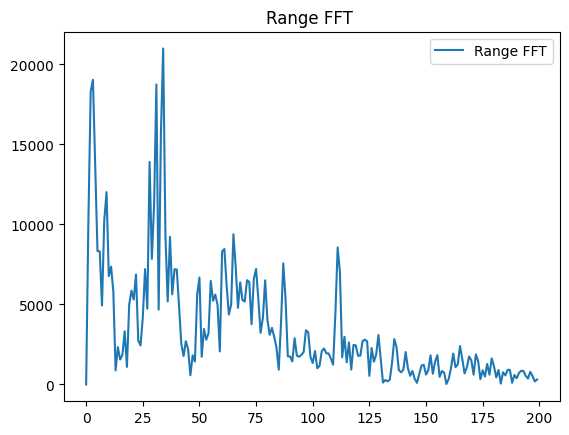

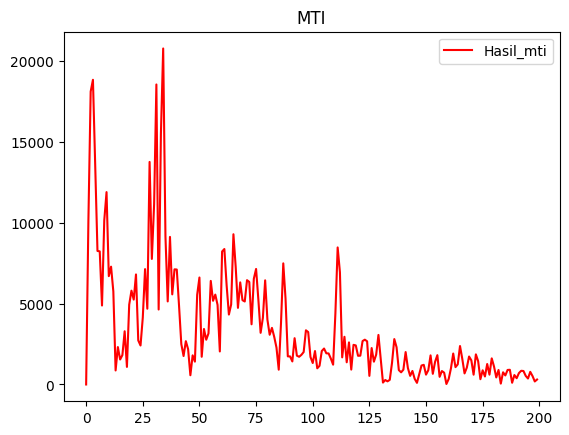

In [11]:
# Visualisasi Data 
plt.figure(1)
plt.title("Raw Data Antena-1-frame-1")
plt.plot(raw_new[0,:,1].real,label="real data")
plt.plot(raw_new[0,:,1].imag,label="imaginary")
plt.legend()
plt.figure(2)
plt.title("Range FFT ")
plt.plot(abs(FFT_hasil[0,:,1][:200]),label="Range FFT")
plt.legend()
plt.figure(3)
plt.title("MTI")
plt.plot(abs(Hasil_mti[0,:,1][:200]),label="Hasil_mti",color='r')
plt.legend()

In [12]:
import numpy as np

# Map Lokasinya 
def map_loc(data_mti):
    Range_Map_An1 = []
    index_max = []
    for i in range(1, data_len):
        # Input data From MTI each Antenna 
        awal_an1 = data_mti[:, i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:60]) #pilih batas jarak
        rslt_peak_1 = 25 + peak_loc_an1
        if i > 1 and abs(rslt_peak_1 - index_max[-1]) == 10:
            # Jika perbedaan adalah 10, pilih peak tertinggi kedua
            abs_mti_1[peak_loc_an1] = 0  # Hilangkan peak pertama
            peak_loc_an1 = np.argmax(abs_mti_1[25:60])
            rslt_peak_1 = 25 + peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

# Contoh penggunaan
map_locA1, Map_loc_An1 = np.array(map_loc(Antena1))
map_locA2, Map_loc_An2 = np.array(map_loc(Antena2))
map_locA3, Map_loc_An3 = np.array(map_loc(Antena3))
map_locA4, Map_loc_An4 = np.array(map_loc(Antena4))


In [13]:
# Phase Extraction
from f_dacm import dacm
from f_noise_RM import remove_noise

DACM_An1 = np.array(dacm(np.array(Map_loc_An1)))
DACM_An2 = np.array(dacm(np.array(Map_loc_An2)))
DACM_An3 = np.array(dacm(np.array(Map_loc_An3)))
DACM_An4 = np.array(dacm(np.array(Map_loc_An4)))

Text(0.5, 0, 'Number of Samples')

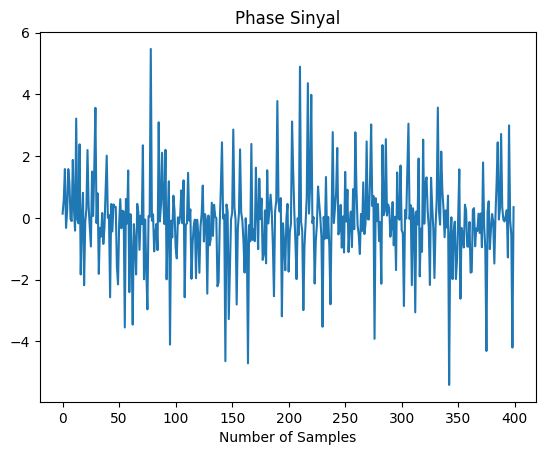

In [14]:
# 
plt.title("Phase Sinyal")
plt.plot(DACM_An1[:400])
plt.xlabel("Number of Samples")

In [15]:
from f_noise_RM import remove_noise
NR_1 = remove_noise(DACM_An1)
NR_2 = remove_noise(DACM_An2)
NR_3 = remove_noise(DACM_An3)
NR_4 = remove_noise(DACM_An4)

In [16]:
len(NR_1)

2995

In [17]:
from scipy.signal import butter, sosfiltfilt, filtfilt,lfilter
def _butter_bandpass1(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    # b, a = butter(order, [low, high], btype='band')
    return sos
def _butter_bandpass2(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # sos = butter(order, [low, high], btype="band", output="sos")
    b, a = butter(order, [low, high], btype='band')
    return b,a
def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    sos = _butter_bandpass1(lowcut, highcut, fs, order=order)
    b,a = _butter_bandpass2(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    y2 = filtfilt(b,a, signal)
    return y


In [18]:
low = 0.1
high = 0.5
fs = 20
BPF_RR1= np.array(butter_bandpass_filter(NR_1,low,high,fs,order=3))
BPF_RR2 = np.array(butter_bandpass_filter(NR_2,low,high,fs,order=3))
BPF_RR3 = np.array(butter_bandpass_filter(NR_3,low,high,fs,order=3))
BPF_RR4 = np.array(butter_bandpass_filter(NR_4,low,high,fs,order=3))

In [19]:
lowhr =0.8
highhr = 2.0
fs = 20
BPF_HR1 = np.array(butter_bandpass_filter(NR_1,lowhr,highhr,fs,order=6))
BPF_HR2 = np.array(butter_bandpass_filter(NR_2,lowhr,highhr,fs,order=6))
BPF_HR3 = np.array(butter_bandpass_filter(NR_3,lowhr,highhr,fs,order=6))
BPF_HR4 = np.array(butter_bandpass_filter(NR_4,lowhr,highhr,fs,order=6))

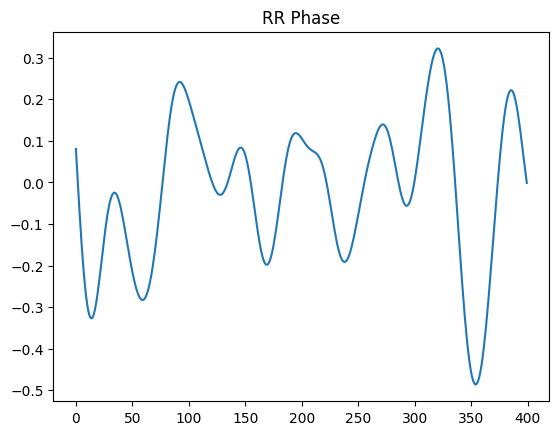

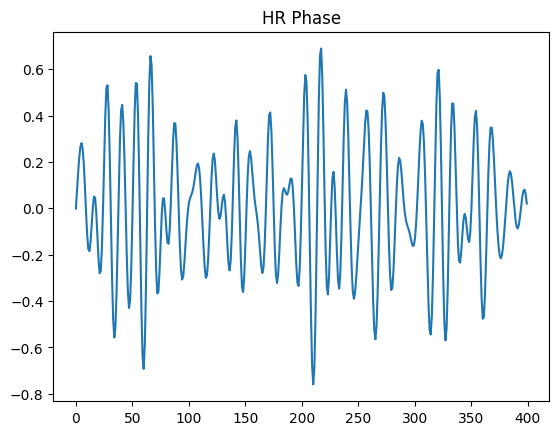

In [20]:
plt.figure(1)
plt.title("RR Phase")
plt.plot(BPF_RR1[:400],label="RR Phase")
plt.figure(2)
plt.title("HR Phase")
plt.plot(BPF_HR1[:400],label="HR Phase")

In [21]:
RR_WAVE[41:1541].shape

(1500,)

In [22]:
ECG[324:19824].shape

(19459,)

In [23]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

rr_resampled_signal = []

pt = PowerTransformer()

rr_norm = pt.fit_transform(RR_WAVE[25:1525].reshape(-1, 1))

rr_resampled = signal.resample(rr_norm, 3000)

rr_resampled_signal.append(rr_resampled)
    
rr_resampled_signal = np.array(rr_resampled_signal)
print(rr_resampled_signal.shape)


(1, 3000, 1)


In [24]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=0.8, highcut=2.0, fs=130, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

In [25]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

hr_resampled_signal = []

pt = PowerTransformer()

hr_bpf = bandpass_filter(ECG[141:19641])

hr_norm = pt.fit_transform(hr_bpf.reshape(-1, 1))

hr_resampled = signal.resample(hr_norm, 19500)

hr_resampled_signal.append(hr_resampled)
    
hr_resampled_signal = np.array(hr_resampled_signal)
print(hr_resampled_signal.shape)

(1, 19500, 1)


In [26]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

rr_resampled_phase = []

pt = PowerTransformer()

rr_norm1 = pt.fit_transform(BPF_RR1.reshape(-1, 1))
rr_norm2 = pt.fit_transform(BPF_RR2.reshape(-1, 1))
rr_norm3 = pt.fit_transform(BPF_RR3.reshape(-1, 1))
rr_norm4 = pt.fit_transform(BPF_RR4.reshape(-1, 1))

rr_resampled1 = signal.resample(rr_norm1, 3000)
rr_resampled2 = signal.resample(rr_norm2, 3000)
rr_resampled3 = signal.resample(rr_norm3, 3000)
rr_resampled4 = signal.resample(rr_norm4, 3000)

rr_resampled_phase.append(rr_resampled1)
rr_resampled_phase.append(rr_resampled2)
rr_resampled_phase.append(rr_resampled3)
rr_resampled_phase.append(rr_resampled4)
    
rr_resampled_phase = np.array(rr_resampled_phase)
print(rr_resampled_phase.shape)


(4, 3000, 1)


In [27]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

hr_resampled_phase = []

pt = PowerTransformer()

hr_norm1 = pt.fit_transform(BPF_HR1.reshape(-1, 1))
hr_norm2 = pt.fit_transform(BPF_HR2.reshape(-1, 1))
hr_norm3 = pt.fit_transform(BPF_HR3.reshape(-1, 1))
hr_norm4 = pt.fit_transform(BPF_HR4.reshape(-1, 1))

hr_resampled1 = signal.resample(hr_norm1, 19500)
hr_resampled2 = signal.resample(hr_norm2, 19500)
hr_resampled3 = signal.resample(hr_norm3, 19500)
hr_resampled4 = signal.resample(hr_norm4, 19500)

hr_resampled_phase.append(hr_resampled1)
hr_resampled_phase.append(hr_resampled2)
hr_resampled_phase.append(hr_resampled3)
hr_resampled_phase.append(hr_resampled4)
    
hr_resampled_phase = np.array(hr_resampled_phase)
print(hr_resampled_phase.shape)

(4, 19500, 1)


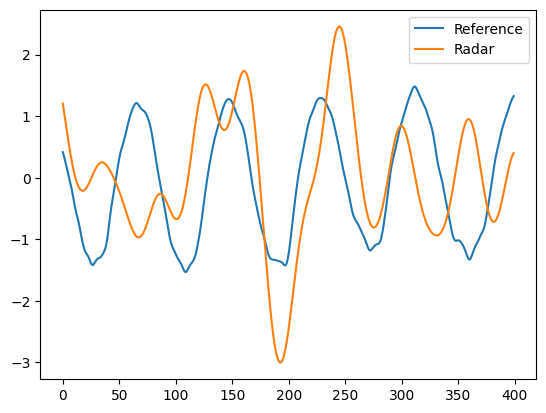

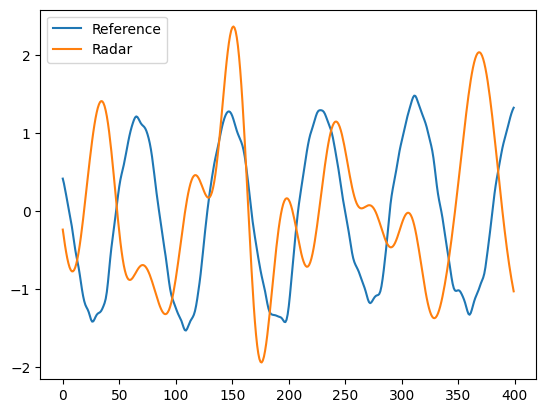

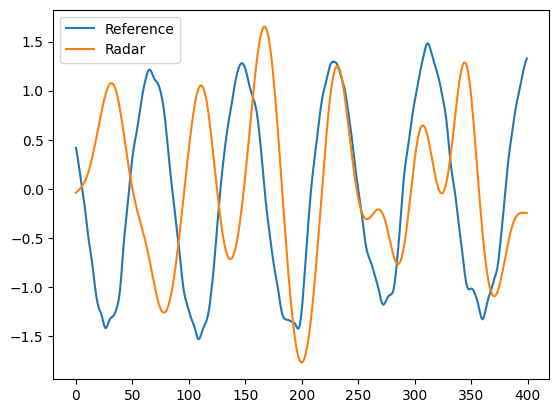

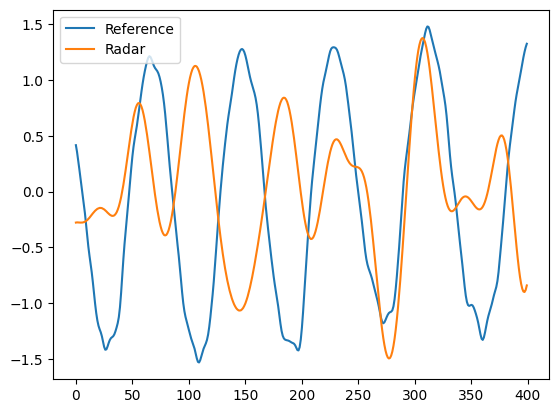

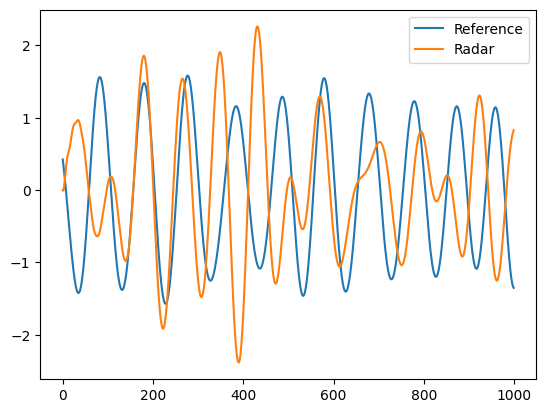

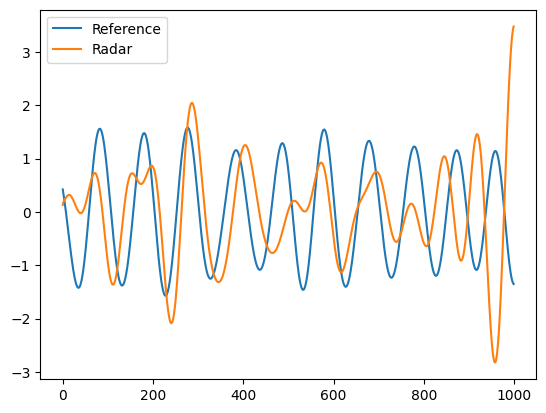

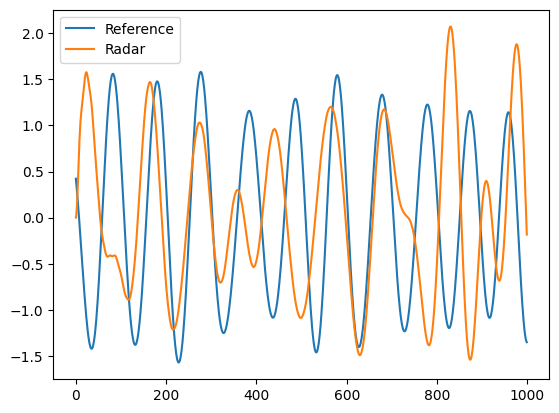

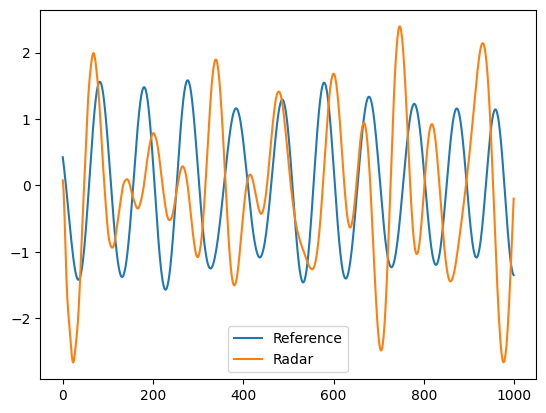

In [28]:
plt.figure(1)
plt.plot(rr_resampled_signal[0,800:1200], label="Reference")
plt.plot(rr_resampled_phase[0,800:1200], label='Radar')
plt.legend()
plt.figure(2)
plt.plot(rr_resampled_signal[0,800:1200], label="Reference")
plt.plot(rr_resampled_phase[1,800:1200], label='Radar')
plt.legend()
plt.figure(3)
plt.plot(rr_resampled_signal[0,800:1200], label="Reference")
plt.plot(rr_resampled_phase[2,800:1200], label='Radar')
plt.legend()
plt.figure(4)
plt.plot(rr_resampled_signal[0,800:1200], label="Reference")
plt.plot(rr_resampled_phase[3,800:1200], label='Radar')
plt.legend()
plt.figure(5)
plt.plot(hr_resampled_signal[0,0:1000], label="Reference")
plt.plot(hr_resampled_phase[0,0:1000], label='Radar')
plt.legend()
plt.figure(6)
plt.plot(hr_resampled_signal[0,0:1000], label="Reference")
plt.plot(hr_resampled_phase[1,0:1000], label='Radar')
plt.legend()
plt.figure(7)
plt.plot(hr_resampled_signal[0,0:1000], label="Reference")
plt.plot(hr_resampled_phase[2,0:1000], label='Radar')
plt.legend()
plt.figure(8)
plt.plot(hr_resampled_signal[0,0:1000], label="Reference")
plt.plot(hr_resampled_phase[3,0:1000], label='Radar')
plt.legend()

In [29]:
import numpy as np
import scipy.fftpack as fftpack
# Temporal bandpass filter with Fast-Fourier Transform
def fft_filter(data, freq_min, freq_max, fs):
    fft = fftpack.fft(data, axis=0)
    frequencies = fftpack.fftfreq(data.shape[0], d=1.0 / fs)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff = fftpack.ifft(fft, axis=0)
    result = np.abs(iff)
    result *= 100  # Amplification factor

    return result, fft, frequencies

In [30]:
from scipy import signal
# Calculate heart rate from FFT peaks
def find_heart_rate(fft, freqs, freq_min, freq_max):
    fft_maximums = []

    for i in range(fft.shape[0]):
        if freq_min <= freqs[i] <= freq_max:
            fftMap = abs(fft[i])
            fft_maximums.append(fftMap.max())
        else:
            fft_maximums.append(0)

    peaks, properties = signal.find_peaks(fft_maximums)
    max_peak = -1
    max_freq = 0

    # Find frequency with max amplitude in peaks
    for peak in peaks:
        if fft_maximums[peak] > max_freq:
            max_freq = fft_maximums[peak]
            max_peak = peak

    return freqs[max_peak] * 60

In [31]:
# Kalman 
def kalman_filter(z_ppg1):

    Q=20**2
    R=2**2

    count=0
    countmax=5
    imax=3

    xposteriori=z_ppg1[0]
    res = np.zeros(len(z_ppg1))
    res[0]=z_ppg1[0]
    Pposteriori=0
    hasil =[]

    for i in range (1, len(z_ppg1)):

        xpriori=xposteriori
        Ppriori=Pposteriori+Q

        S=Ppriori+R
        gain=Ppriori/S

        inn1=z_ppg1[i]-xpriori

        if (((count==countmax or i<imax) and ~np.isnan(inn1))):
            inn=inn1
            xposteriori=xpriori+gain*inn
            Pposteriori=(1-gain)*Ppriori
            if(count==countmax ):
                xposteriori=0.5*(z_ppg1[i]+xpriori)
            count=0

        else:
            count=count+1
            xposteriori=xpriori
            Pposteriori=Ppriori

        res[i]=xposteriori
        hasil.append(xposteriori)

    return hasil

In [32]:
def bpm_hr(data):
    hasil =[]
    for i in range(data.shape[0]):
        freq_min = 1.4
        freq_max = 1.6
        fs = 20
        result, fft, frequencies = fft_filter(data[i], freq_min, freq_max, fs)
        heart_rate = find_heart_rate(fft, frequencies, freq_min, freq_max)
        hasil.append(heart_rate)
    return hasil 
def bpm_rr(data):
    hasil =[]
    for i in range(data.shape[0]):
        freq_min = 0.2
        freq_max = 0.3
        fs = 20
        result, fft, frequencies = fft_filter(data[i], freq_min, freq_max, fs)
        heart_rate = find_heart_rate(fft, frequencies, freq_min, freq_max)
        hasil.append(heart_rate)
    return hasil 
        

In [33]:
def slide_win_rr(data):
    isi_dataVT =[]
    for i in range(131):
        if i == 0:
            index_1 = i
        else :
            index_1 = index_2 - 380
        index_2 = index_1 + 400
        vt_20s_1 = data[index_1:index_2]
    #print(index_1,index_2)
        isi_dataVT.append(vt_20s_1)

    return isi_dataVT

In [34]:
def slide_win_hr(data):
    isi_dataVT =[]
    for i in range(131):
        if i == 0:
            index_1 = i
        else :
            index_1 = index_2 - 2470
        index_2 = index_1 + 2600
        vt_20s_1 = data[index_1:index_2]
    #print(index_1,index_2)
        isi_dataVT.append(vt_20s_1)

    return isi_dataVT

In [35]:
slide_an1_rr = np.array(slide_win_rr(rr_resampled_phase[0]),dtype=object)
slide_an2_rr = np.array(slide_win_rr(rr_resampled_phase[1]),dtype=object)
slide_an3_rr = np.array(slide_win_rr(rr_resampled_phase[2]),dtype=object)
slide_an4_rr = np.array(slide_win_rr(rr_resampled_phase[3]),dtype=object)
slide_ref_rr = np.array(slide_win_rr(rr_resampled_signal[0,:,:]),dtype=object)

slide_an1_hr = np.array(slide_win_hr(hr_resampled_phase[0]),dtype=object)
slide_an2_hr = np.array(slide_win_hr(hr_resampled_phase[1]),dtype=object)
slide_an3_hr = np.array(slide_win_hr(hr_resampled_phase[2]),dtype=object)
slide_an4_hr = np.array(slide_win_hr(hr_resampled_phase[3]),dtype=object)
slide_ref_hr = np.array(slide_win_hr(hr_resampled_signal[0,:,:]),dtype=object)

In [36]:
slide_ref_rr.shape

(131, 400, 1)

In [37]:
hr_1 = np.array(bpm_hr(slide_an1_hr))
hr_2 = np.array(bpm_hr(slide_an2_hr))
hr_3 = np.array(bpm_hr(slide_an3_hr))
hr_4 = np.array(bpm_hr(slide_an4_hr))
hr_ref = np.array(bpm_hr(slide_ref_hr))
rr_1 = np.array(bpm_rr(slide_an1_rr))
rr_2 = np.array(bpm_rr(slide_an2_rr))
rr_3 = np.array(bpm_rr(slide_an3_rr))
rr_4 = np.array(bpm_rr(slide_an4_rr))
rr_ref = np.array(bpm_rr(slide_ref_rr))

In [38]:
total_hr = (hr_1+hr_2+hr_3+hr_4)/4
hasil_hr = kalman_filter(total_hr)
total_rr = (rr_1+rr_2+rr_3+rr_4)/4
hasil_rr = kalman_filter(total_rr)

In [39]:
hr_ref_kalman = kalman_filter(hr_ref)
rr_ref_kalman = kalman_filter(rr_ref)

In [40]:
print(max(HR))
print(min(HR))
print(max(rr_ref_kalman))
print(min(rr_ref_kalman))

111
81
15.0
15.0


In [41]:
print(sum(HR)/len(HR))

88.50326797385621


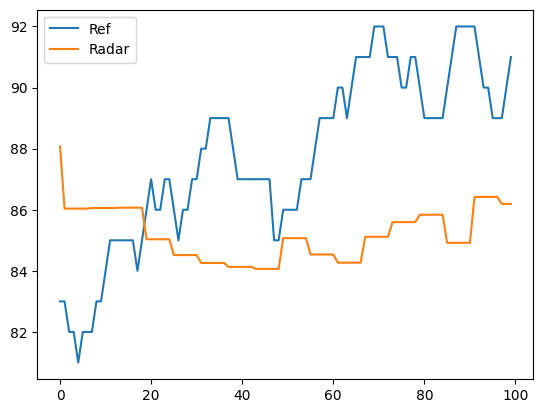

In [42]:
plt.plot(HR[-100:], label="Ref")
# print(len(HR_Polar))
# plt.plot(hasil_hr2, label='kalman 1')
plt.plot(hasil_hr[-100:], label='Radar')
plt.legend()

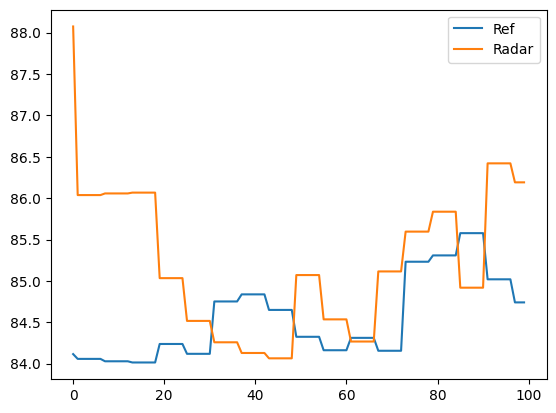

In [43]:
plt.plot(hr_ref_kalman[-100:], label="Ref")
# print(len(HR_Polar))
# plt.plot(hasil_hr2, label='kalman 1')
plt.plot(hasil_hr[-100:], label='Radar')
plt.legend()

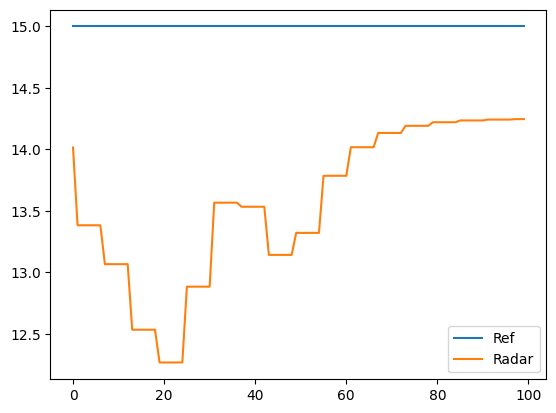

In [44]:
plt.plot(rr_ref_kalman[-105:-5], label="Ref")
# print(len(HR_Polar))
# plt.plot(hasil_hr2, label='kalman 1')
plt.plot(hasil_rr[-100:], label='Radar')
plt.legend()

In [45]:
import math
from sklearn.metrics import mean_squared_error
def RMSE(actual, predicted):
    y_actual = actual
    y_predicted =predicted
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = math.sqrt(MSE)
    return np.round(RMSE,2)

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    m =np.mean(np.abs(y_true - predictions))
    return np.round(m,2)
def round_data(data):
    f = np.array([round(x) for x in data]).astype(int)
    return f 

In [46]:
print(f"RMSE: {RMSE(HR[-100:], hasil_hr[-100:])}")
print(f"MAE: {mae(HR[-100:], hasil_hr[-100:])}")

RMSE: 4.03
MAE: 3.59


In [47]:
print(f"RMSE: {RMSE(hr_ref_kalman[-100:], hasil_hr[-100:])}")
print(f"MAE: {mae(hr_ref_kalman[-100:], hasil_hr[-100:])}")

RMSE: 1.15
MAE: 0.93


In [48]:
print(f"RMSE: {RMSE(rr_ref_kalman, hasil_rr)}")
print(f"MAE: {mae(rr_ref_kalman, hasil_rr)}")

RMSE: 1.52
MAE: 1.41


(4, 3000, 1)


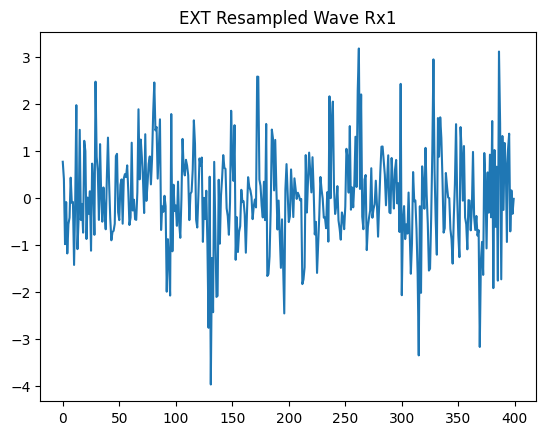

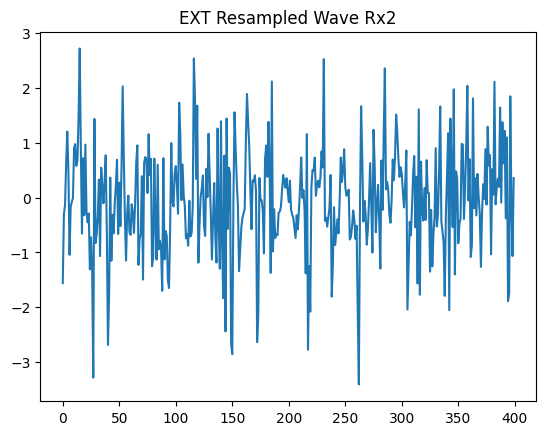

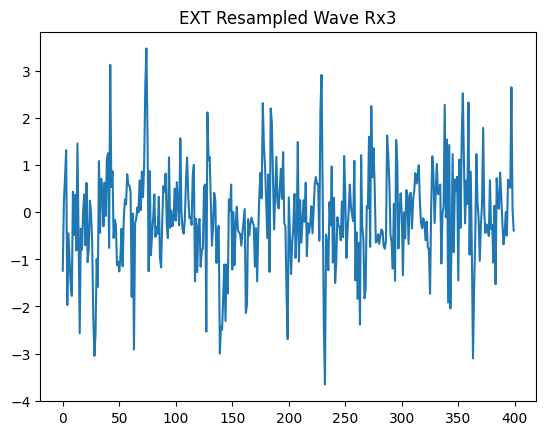

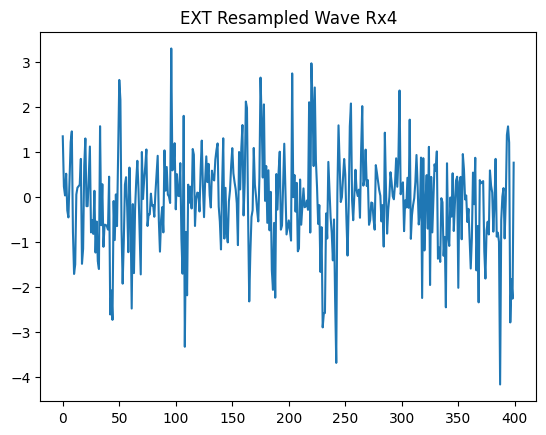

In [49]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

ext_resampled_phase = []

pt = PowerTransformer()

ext_norm1 = pt.fit_transform(np.array(NR_1).reshape(-1, 1))
ext_norm2 = pt.fit_transform(np.array(NR_2).reshape(-1, 1))
ext_norm3 = pt.fit_transform(np.array(NR_3).reshape(-1, 1))
ext_norm4 = pt.fit_transform(np.array(NR_4).reshape(-1, 1))

ext_resampled1 = signal.resample(ext_norm1, 3000)
ext_resampled2 = signal.resample(ext_norm2, 3000)
ext_resampled3 = signal.resample(ext_norm3, 3000)
ext_resampled4 = signal.resample(ext_norm4, 3000)

ext_resampled_phase.append(ext_resampled1)
ext_resampled_phase.append(ext_resampled2)
ext_resampled_phase.append(ext_resampled3)
ext_resampled_phase.append(ext_resampled4)
    
ext_resampled_phase = np.array(ext_resampled_phase)
print(ext_resampled_phase.shape)
plt.figure(1)
plt.title("EXT Resampled Wave Rx1")
plt.plot(ext_resampled_phase[0,400:800],label="EXT Resampled Wave")
plt.figure(2)
plt.title("EXT Resampled Wave Rx2")
plt.plot(ext_resampled_phase[1,400:800],label="EXT Resampled Wave")
plt.figure(3)
plt.title("EXT Resampled Wave Rx3")
plt.plot(ext_resampled_phase[2,400:800],label="EXT Resampled Wave")
plt.figure(4)
plt.title("EXT Resampled Wave Rx4")
plt.plot(ext_resampled_phase[3,400:800],label="EXT Resampled Wave")


(4, 19500, 1)


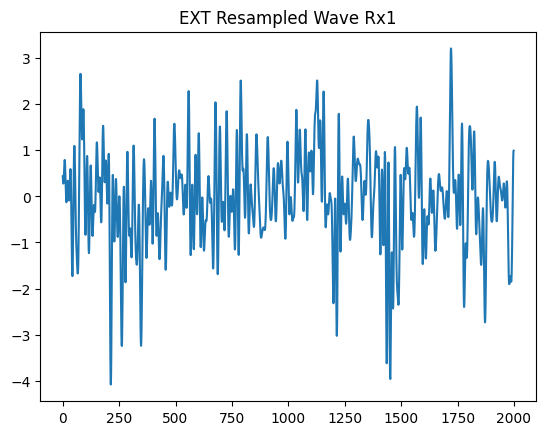

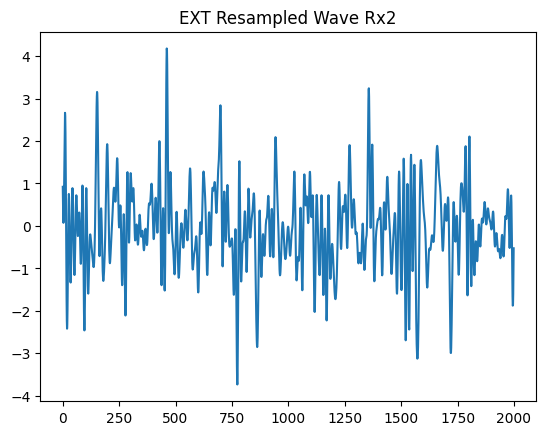

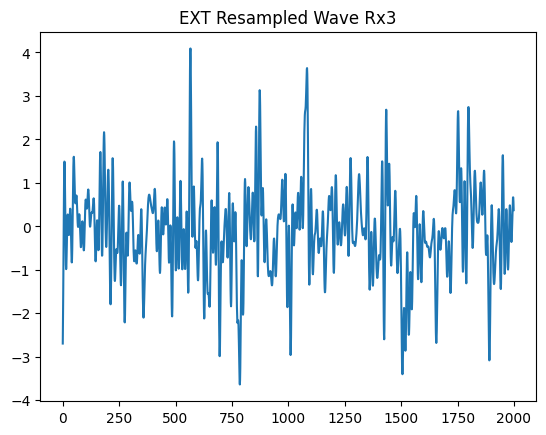

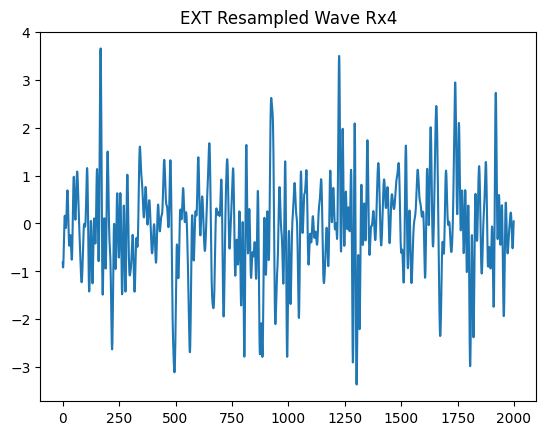

In [50]:
from sklearn.preprocessing import PowerTransformer
from scipy import signal

ext_hr_resampled_phase = []

pt = PowerTransformer()

ext_hr_norm1 = pt.fit_transform(np.array(NR_1).reshape(-1, 1))
ext_hr_norm2 = pt.fit_transform(np.array(NR_2).reshape(-1, 1))
ext_hr_norm3 = pt.fit_transform(np.array(NR_3).reshape(-1, 1))
ext_hr_norm4 = pt.fit_transform(np.array(NR_4).reshape(-1, 1))

ext_hr_resampled1 = signal.resample(ext_hr_norm1, 19500)
ext_hr_resampled2 = signal.resample(ext_hr_norm2, 19500)
ext_hr_resampled3 = signal.resample(ext_hr_norm3, 19500)
ext_hr_resampled4 = signal.resample(ext_hr_norm4, 19500)

ext_hr_resampled_phase.append(ext_hr_resampled1)
ext_hr_resampled_phase.append(ext_hr_resampled2)
ext_hr_resampled_phase.append(ext_hr_resampled3)
ext_hr_resampled_phase.append(ext_hr_resampled4)
    
ext_hr_resampled_phase = np.array(ext_hr_resampled_phase)
print(ext_hr_resampled_phase.shape)
plt.figure(1)
plt.title("EXT Resampled Wave Rx1")
plt.plot(ext_hr_resampled_phase[0,2000:4000],label="EXT Resampled Wave")
plt.figure(2)
plt.title("EXT Resampled Wave Rx2")
plt.plot(ext_hr_resampled_phase[1,2000:4000],label="EXT Resampled Wave")
plt.figure(3)
plt.title("EXT Resampled Wave Rx3")
plt.plot(ext_hr_resampled_phase[2,2000:4000],label="EXT Resampled Wave")
plt.figure(4)
plt.title("EXT Resampled Wave Rx4")
plt.plot(ext_hr_resampled_phase[3,2000:4000],label="EXT Resampled Wave")


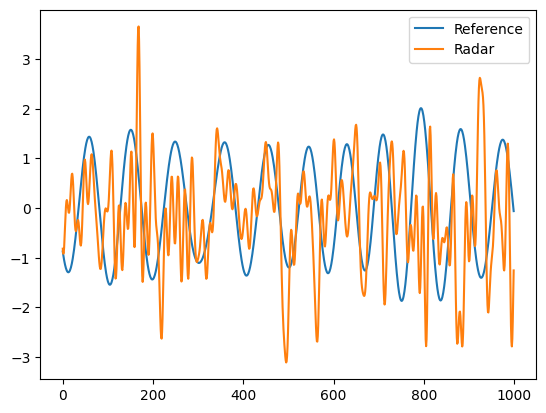

In [51]:
plt.plot(hr_resampled_signal[0,2000:3000], label="Reference")
plt.plot(ext_hr_resampled_phase[3,2000:3000], label='Radar')
plt.legend()

In [52]:
print(rr_resampled_phase.shape)
print(rr_resampled_signal.shape)
print(hr_resampled_phase.shape)
print(hr_resampled_signal.shape)
print(ext_resampled_phase.shape)
print(ext_hr_resampled_phase.shape)

(4, 3000, 1)
(1, 3000, 1)
(4, 19500, 1)
(1, 19500, 1)
(4, 3000, 1)
(4, 19500, 1)


In [53]:
import csv

In [54]:
for j in range(4):
    with open('rr_wave.csv', 'a') as f: 
        # Create a CSV writer object that will write to the file 'f'
        csv_writer = csv.writer(f)
    
        # Write all of the rows of data to the CSV file
        csv_writer.writerows([rr_resampled_signal.squeeze()])
    with open('hr_wave.csv', 'a') as f: 
        # Create a CSV writer object that will write to the file 'f'
        csv_writer = csv.writer(f)
    
        # Write all of the rows of data to the CSV file
        csv_writer.writerows([hr_resampled_signal.squeeze()])

In [55]:
with open('rr_phase.csv', 'a') as f: 
    # Create a CSV writer object that will write to the file 'f'
    csv_writer = csv.writer(f)

    # Write all of the rows of data to the CSV file
    csv_writer.writerows([rr_resampled_phase[0].squeeze()])
    csv_writer.writerows([rr_resampled_phase[1].squeeze()])
    csv_writer.writerows([rr_resampled_phase[2].squeeze()])
    csv_writer.writerows([rr_resampled_phase[3].squeeze()])
with open('hr_phase.csv', 'a') as f: 
    # Create a CSV writer object that will write to the file 'f'
    csv_writer = csv.writer(f)

    # Write all of the rows of data to the CSV file
    csv_writer.writerows([hr_resampled_phase[0].squeeze()])
    csv_writer.writerows([hr_resampled_phase[1].squeeze()])
    csv_writer.writerows([hr_resampled_phase[2].squeeze()])
    csv_writer.writerows([hr_resampled_phase[3].squeeze()])
with open('ext_rr_phase.csv', 'a') as f: 
    # Create a CSV writer object that will write to the file 'f'
    csv_writer = csv.writer(f)

    # Write all of the rows of data to the CSV file
    csv_writer.writerows([ext_resampled_phase[0].squeeze()])
    csv_writer.writerows([ext_resampled_phase[1].squeeze()])
    csv_writer.writerows([ext_resampled_phase[2].squeeze()])
    csv_writer.writerows([ext_resampled_phase[3].squeeze()])
with open('ext_hr_phase.csv', 'a') as f: 
    # Create a CSV writer object that will write to the file 'f'
    csv_writer = csv.writer(f)

    # Write all of the rows of data to the CSV file
    csv_writer.writerows([ext_hr_resampled_phase[0].squeeze()])
    csv_writer.writerows([ext_hr_resampled_phase[1].squeeze()])
    csv_writer.writerows([ext_hr_resampled_phase[2].squeeze()])
    csv_writer.writerows([ext_hr_resampled_phase[3].squeeze()])